# 3. Filtros FIR (Implementación)

Como se explicó en la Sección 1.2, un sistema mínimo de procesamiento digital de señales está compuesto por un procesador (DSP: _Digital Signal Processor_), que se encarga de implementar los algoritmos de cómputo, y unos conversores analógico-digital (ADC) y digital-analógico (DAC) para muestrear la señal de entrada y entregar la señal calculada al mundo externo, respectivamente.  

![Sistema Básico de Procesamiento Digital de Señales](../img/SistemaDSP.png)

Hasta el momento se ha mostrado que el diseño de filtros digitales FIR se limita a calcular la respuesta al impulso $h[n]$ y para su implementación basta con escribir un algoritmo que calcule la sumatoria de convolución:

$$y[n]=x[n]\star h[n]=\sum_{k=0}^{N_{h}-1}h[k]\!x[n-k]$$

Es decir, en el diagrama de bloques mostrado anteriormente, el DSP debe capturar la señal de entrada del ADC, $x[n]$, calcular la sumatoria de convolución para producir $y[n]$, y escribir $y[n]$ en el DAC. Este proceso se debe repetir continuamente, por cada muestra de entrada, cada periodo de muestreo $T_s$, siguiendo un esquema como el mostrado en el siguiente código en C: 

```C
void loop() {
    float x = LeerADC();
    float y = filtrar(x);
    EscribirDAC(y);
    EsperarSiguienteTs();
}
```

Para entender cómo implementar la función ``filtrar``, expandamos los términos de la sumatoria de convolución

$$y[n]=h[0]x[n] + h[1]x[n-1] + h[2]x[n-2] + ... + h[N_h-1] x[n-(N_h-1)]$$

En esta ecuación, $x[n]$ representa la entrada actual, $x[n-1]$ la entrada anterior, $x[n-2]$ la entrada anterior-anterior, etc., por lo tanto, podemos observar que $y[n]$, o la salida actual, será la suma de la entrada actual afectada por un factor $h[0]$, más la entrada anterior multiplicada por $h[1]$, y así sucesivamente, hasta cubrir toda la longitud de la respuesta al impulso. 

Computacionalmente, $y[n]$ representa la salida actual del sistema, es decir el valor que se debe escribir en el conversor digital-analógico (DAC) una vez calculada la convolución, por lo tanto, no se trata de ningún arreglo de elementos. $h[k]$ por su parte, podemos asociarlo a un arreglo fijo de $N_{h}$ elementos pre-calculados con la respuesta al impulso y $x[n-k]$, se trata de otro arreglo, también de longitud $N_{h}$, pero sus elementos se modifican en la medida que ingresan nuevas muestras entregadas por el conversor digital-analógico (ADC). En la siguiente tabla se muestra la asociación que tiene cada elemento del arreglo de datos ``x`` que tendrá nuestro programa en C con el término que aparece en la ecuación de la sumatoria de convolución.

| Término en C | Término en la ecuación de convolución | Significado |
|------|------|------|
| ``x[0]`` | $x[n]$ | Muestra actual del ADC |
| ``x[1]`` | $x[n-1]$ | Muestra anterior |
| ``x[2]`` | $x[n-2]$ | Muestra anterior a la anterior |
| ``x[3]`` | $x[n-3]$ | Muestra hace 3 instantes de tiempo |

Es importante recalcar que no se debe esperar a que el arreglo ``x`` esté completamente lleno para así proceder a calcular la sumatoria, en su lugar, la muestra leída del ADC se almacena en la posición ``x[0]`` del arreglo, se calcula la sumatoria con un ciclo ``for`` y se realiza un movimiento de datos en el arreglo ``x``, con un segundo ciclo ``for``, con el fin de que en la siguiente iteración la muestra actual sea la anterior, la anterior se convierta en la anterior-anterior, etc., siguiendo la asociación mostrada en la tabla anterior. El algoritmo resultante en lenguaje C se muestra a continuación.

```C
#define Nh 21
float h[Nh] = { -0.013, 0.026, .... };
float x[Nh];

float filtrar(float x_ADC) {
    int k;
    float y;
    x[0] = x_ADC;
    //Cálculo de la convolución
    y = 0;
    for(k=0; k<Nh; k++) {
        y += h[k]*x[k];
    }
    //Movimiento de datos del arreglo x
    for(k=Nh-1; k>0; k--) {
        x[k] = x[k-1];
    }
    return y;
}
````

En los siguientes enlaces al simulador en linea **Wokwi** se encuentra la implementación de un filtro digital FIR usando el código mostrado sobre un micro-controlador ESP32: 

(a) Usando E/S Programada (https://wokwi.com/projects/406323503999269889) y 

(b) Usando E/S por Interrupción (https://wokwi.com/projects/406690352968126465). 

El programa ha sido adaptado para reemplazar ``LeerADC`` y ``EscribirDAC`` por funciones propias de la plataforma y al hardware disponible. Si no está familiarizado con la terminología de esquema de E/S Programada y E/S por Interrupción consulte el **Apéndice B** para aprender sobre  los mecanismos de entrada/salida disponibles en los sistemas basados en procesador.

El algoritmo presentado es implementación denominada implementación **orientada a muestras**, porque la estructura básica de cómputo consiste en leer una muestra del ADC, procesarla y escribir inmediatamente la muestra calculada en el DAC. Este tipo de implementación es útil cuando las muestras se adquieren por los métodos de entrada/salida programada (también llamada _polling_) o entrada/salida por interrupción. Cuando la adquisición de los datos se realiza por la técnica de entrada/salida por acceso directo a memoria o DMA (por las siglas en inglés de _Direct Memory Access_), es más eficiente escribir el algoritmo de la convolución usando una implementación **orientada a bloque** cuyo su algoritmo difiere del mostrado anteriormente. Este algoritmo, al igual que formas alternativas y optimizadas para el cómputo de la sumatoria de convolución serán abordas en la siguiente sección.

El programa en C mostrado arriba asume que se cuenta declarado en el código un arreglo ``h`` de longitud igual a la respuesta al impulso ``Nh``. En el [programa de referencia](https://wokwi.com/projects/406323503999269889), estos valores se encuentran en un archivo de cabecera llamado ``coeffs.h``. Este archivo puede generarse en Python después de haber realizado el diseño de $h[n]$ usando el siguiente código ejemplo.

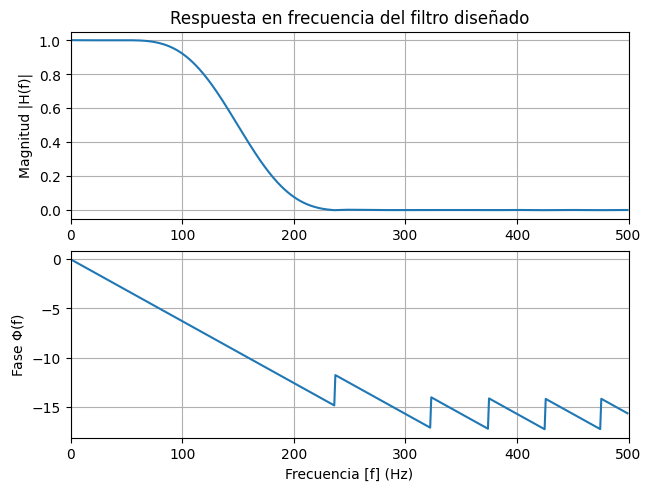

In [1]:
#Ejemplo 3.1. Diseño de un filtro y generación del archivo de para usar en el programa en C
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig

#Cálculo de la respuesta al impulso de un filtro pasa-bajo de fc=150Hz @ fs=1kHz
fs = 1000
fc = 150
Omegac = 2*np.pi*fc/fs
Nh = 21
n = np.arange(-(Nh-1)/2, (Nh-1)/2 + 1)
hD = (Omegac/np.pi) * np.sinc(n*(Omegac/np.pi))
hw = hD * np.hamming(Nh)

#Grafica la respuesta en frecuencia en Hertz
w, Hw = sig.freqz(hw)
fig, axs = plt.subplots(2,1,layout='constrained')
axs[0].plot((fs/2) * w/np.pi, np.abs(Hw))
axs[0].set_ylabel(r'Magnitud |H(f)|')
axs[0].set_title('Respuesta en frecuencia del filtro diseñado')
axs[0].set(xlim=(0,fs/2))
axs[0].grid()
axs[1].plot((fs/2) * w/np.pi, np.unwrap(np.angle(Hw)))
axs[1].set_xlabel(r'Frecuencia [f] (Hz)')
axs[1].set_ylabel(r'Fase $\Phi$(f)')
axs[1].set(xlim=(0,fs/2))
axs[1].grid()
plt.show()

#Exporta los coeficientes al archivo coeffs.h
with open('coeffs.h', 'w') as file:
    file.write(f'#define Nh {len(hw)}\n')
    file.write('const float h[] = {\n')
    for hsample in hw:
        file.write(f"\t {hsample}, \n")
    file.write('};\n')
    file.close()


Aunque el programa en lenguaje C mostrado anteriormente calcula la convolución, este método no siempre resulta ser el más eficiente computacionalmente. Para tal efecto, se han creado una serie de estructuras que permiten implementar filtros FIR. Estas estructuras tienen como fin:

* Reducir la complejidad computacional. En procesamiento digital de señales, se toman como criterios para definir el tiempo de ejecución de un algoritmo, tanto el número de multiplicaciones, como de sumas y movimientos en memoria. 

* Disminuir los requisitos de memoria. 

* Disminuir los efectos de las palabras de longitud finita. Cuando se codifica un filtro en un procesador, los coeficientes de la respuesta al impulso se escalan o codifican para ser almacenados en los registros del procesador. Esta conversión introduce desviaciones de la respuesta en frecuencia del filtro original.

Entre las estructuras más comunes para implementación de filtros FIR, están la directa, la simétrica, y la transpuesta, las cuales serán estudiadas en este capítulo, al igual que otras estrategias adicionales de optimización.

## 3.1 Estructura FIR Directa

Los algoritmos que implementan directamente la ecuación de la sumatoria de convolución

$$y[n]=\sum_{k=0}^{N_{h}-1}h[k]\!x[n-k]$$

se denominan **estructura directa**, cuya implementación en C se mostró al inicio de este capítulo. El programa presentado tiene una secuencia de instrucciones que se puede resumir como:

1. Hacer un ciclo ``for`` que calcule $y[n]$ por medio de la sumatoria de convolución.

2. Hacer un ciclo ``for`` que mueva los datos del arreglo ``x``, con el fin de que la muestra actual pase a ser la anterior y así sucesivamente.

Lo anterior implica la siguiente complejidad computacional para la estructura directa:

| Operación | Cantidad |
|------|------|
| Multiplicación (MPY) | $N_h$ |
| Suma (ADD) | $N_h-1$ |
| Movimientos de datos (Delay) | $N_h-1$ |

Nótese que el cálculo de la sumatoria de convolución implica las siguientes líneas de código:

```C
for(k=0; k<Nh; k++) {
    y += h[k]*x[k];
}
```
Los compiladores traducen esta representación a un conjunto de instrucciones de máquina que se puede representar con aritmética de punteros como se muestra a continuación

```C
for(k=0; k<Nh; k++) {
    y += (*(hk++)) * (*(xk++));
}
```
En este programa, la línea de código ``y += (*(hk++)) * (*(xk++))`` corresponde a una única instrucción de máquina de un procesador digital de señales (DSP) que se conoce con el nombre de **MAC** (**M**ultiplicación-**AC**umulación) y es el corazón de la unidad aritmético-lógica de dichos procesadores o en implementaciones sobre arquitecturas digitales como FPGA. Como puede verse, un MAC realiza 3 cosas a saber: multiplica el elemento apuntado por ``hk`` por el elemento apuntado por ``xk``, el producto resultante se suma al acumulado en ``y``, luego modifica el valor de los punteros ``hk`` y ``xk``, todo en una única instrucción.

Los compiladores modernos son altamente optimizados, por lo cual trabajar con aritmética de punteros es innecesario. Además, la mayoría de los compiladores son capaces de inferir las instrucciones MAC y emplearlas cuando compilan programas como el mostrado en el código de referencia.

Una forma común de describir los algoritmos es por medio de un **diagrama de bloques**. Para la estructura directa, este diagrama se muestra en la siguiente figura, donde puede verse que está compuesto por una cadena en cascada de elementos de retardo ($z^{-1}$), por esta razón, la estructura directa se denomina también **línea de retardos** o **filtro transversal**. Cada elemento de retardo equivale a una celda de memoria (elemento del arreglo ``x``). 

![Diagrama de bloques de la estructura FIR simétrica](../img/cap3_firdirect.png)

Nótese en la figura, que la señal de salida solamente será válida una vez se propague el resultado del producto $b_0 x[n]$ por todos los elementos de suma. Este trayecto se conoce como **ruta crítica** y está relacionada con el **tiempo de latencia** del algoritmo. El tiempo de latencia se refiere al tiempo que tarda en producirse una salida correcta después de inducir un cambio en la entrada y es un factor importante en el diseño de filtros digitales en hardware sobre dispositivos FPGA o ASIC. La ruta crítica de esta estructura es $$1 MPY + (N_h-1) ADD$$ donde MPY y ADD son los tiempos que tarda una operación de multiplicación y suma, respectivamente.  

La notación en diagramas de bloques permite obtener, en forma directa, la implementación en hardware sobre un arreglo de compuertas programables (FPGA). En la siguiente figura se muestra la implementación en hardware de un filtro FIR de 3 coeficientes, en el cual el elemento de retardo $z^{-1}$ se ha reemplazado por un registro de datos. La razón del desplazador de la salida es para eliminar el punto fijo, tema que será explicado en detalle en la Sección 3.4.

![Implementación de filtro FIR en hardware](../img/cap3_fir_fpga.png)

### 3.1.1. Buffers Circulares

Si analizamos la complejidad computacional de la estructura FIR directa, tenemos un total de $N_{h}$ multiplicaciones, $N_{h}-1$ sumas y $N_{h}-1$ movimientos de datos en el arreglo ``x``. El movimiento de datos puede suprimirse si empleamos un buffer circular para almacenar las entradas x. 

| Operación | Estructura directa | Estructura directa con buffer circular |
|------|------|------|
| Multiplicación (MPY) | $N_h$ | $N_h$ |
| Suma (ADD) | $N_h-1$ | $N_h-1$ | 
| Movimientos de datos (Delay) | $N_h-1$ | 0 |

La idea consiste en tener un puntero al arreglo de entradas (``xins``), el cual indica la posición de memoria donde debemos almacenar el dato leído del ADC. Para comprender su funcionamiento, supongamos que tenemos una respuesta al impulso de 6 datos como se muestra en la Figura.

![Buffer circular](../img/cap3_buffer_circular.png)

Inicialmente, el puntero ``xins`` apunta al índice 0 del arreglo ``x``, por ello, esta posición del arreglo será la muestra actual $x[n]$; el índice 1, apunta a la muestra anterior $x[n-1]$, y así sucesivamente hasta completar el arreglo. Cuando se lee un dato del ADC, éste se almacena en la posición apuntada por ``xins`` (posición 0 del arreglo) y se realiza el producto y acumulación de todos los elementos de ``x`` y ``b``, tal como indican las flechas (``y = (xins)*b0 + (xins+1)*b1 + ...``). Después de calcular la convolución, el puntero ``xins`` se decrementa, como se sale del arreglo x, se debe colocar apuntando al último elemento, ya que la muestra ``x[n-5]`` se debe descartar para la siguiente iteración.

En la segunda iteración, el dato leído del ADC se coloca en la posición apuntada por ``xins``, es decir, en la última posición del arreglo. Nótese que sin necesidad de realizar el movimiento de datos, el primer elemento del arreglo, equivale a la muestra anterior $x[n-1]$, el segundo elemento a $x[n-2]$, etc., por lo tanto, para el cálculo de la convolución se debe multiplicar el elemento apuntado por ``xins`` con ``b0``, ``xins+1`` con ``b1``, pero como ``xins+1`` se encuentra fuera del arreglo, se debe tomar el primer elemento del arreglo ``x``. 

Para pasar a la tercera iteración se debe también decrementar el puntero ``xins`` y seguir las multiplicaciones indicadas.

La forma de cálculo de la convolución con el buffer circular se puede entender más simple al asumir el arreglo x como una cinta continua en la cual los índices extremos 0 y 5 están unidos formando un anillo.

En lo expuesto anteriormente se encuentra que es necesario verificar continuamente sí el puntero al arreglo ``xins`` apunta a una dirección de memoria por fuera del arreglo, de cumplirse esta condición se debe hacer un ajuste a dicho puntero. Una primera propuesta, ineficiente, para el algoritmo de cómputo de la convolución circular sería:

```C
float x[Nh];
int xins = 0;

float filtro_bufcircular1(float x_ADC) {
   float y;
   int k, k_h, k_x;
   //Inserta la muestra leída en la posición xins
   x[xins] = x_ADC;
   //Calcula la convolución
   k_h = 0;
   k_x = xins;
   y = 0;
   for(k=0; k<Nh; k++) {
      y += h[k_h++]*x[k_x++];
      if (k_x >= Nh) {
         k_x = 0;
      }
   }
   //Decrementa el puntero de inserción xins
   xins--;
   //Si se sale del arreglo lo inicializa a la última posición del arreglo x
   if (xins < 0) { xins = Nh-1; }
   return y;
}
```

En la codificación de algoritmos en tiempo real se debe tratar en lo posible de eliminar condicionales (sentencias ``if``) al interior de los ciclos ``for``, ya que a nivel de máquina una sentencia ``if`` implica la existencia de instrucciones de salto condicional las que en la mayoría de procesadores consumen una gran cantidad de ciclos de máquina o inducen _cache misses_. Para evitar este tipo de codificación, una alternativa de solución es la partición del ciclo ``for`` en más de un ciclo como se mostrará a continuación. El propósito de la optimización será entonces eliminar el condicional ``if ( k_x >= Nh )``. 

Nótese en el programa de arriba que, al interior del ciclo ``for``, se incrementa el índice ``k_x``, por lo que la condición del ``if`` se ejecuta sólo para un único valor de ``k``. Una vez se cumpla dicha condición, el índice ``k_x`` se carga con 0, apuntando así a la primera posición del arreglo x. Esto invalida la condición del ``if`` para los siguientes valores de ``k``. Otra forma de entender lo anteriormente explicado se aprecia al analizar la tercera iteración en Figura(c). Nótese que al inicio del ciclo ``for`` y antes de que el puntero se salga del arreglo (cumplirse la condición if) hay dos elementos (``x[4]`` y ``x[5]``) que participan en la multiplicación-acumulación. Posteriormente, el puntero se inicializa al primer elemento del arreglo x y se debe repetir cuatro veces la multiplicación-acumulación.

Lo anterior significa que el ciclo ``for`` se puede descomponer en dos: uno que calcule la multiplicación-acumulación desde la posición ``xins`` hasta el final del arreglo, y otro desde el inicio del arreglo ``x`` hasta el elemento ubicado en la posición ``xins-1``. El primero se debe repetir $N_h-x_{ins}$ veces y el segundo $x_{ins}$ veces. La solución final se presenta a continuación:

```C
float x[Nh];
int xins = 0;

float filtro_bufcircular2(float x_ADC) {
   float y;
   int k, k_h, k_x, N1, N2;
   //Inserta la muestra leída en la posición xins
   x[xins] = x_ADC;
   //Determina las longitudes de los dos ciclos for
   N2 = xins;
   N1 = Nh - xins;
   //Calcula la convolución
   k_h = 0;
   k_x = xins;
   y = 0;
   for(k=0; k<N1; k++) {
      y += h[k_h++] * x[k_x++];
   }
   k_x = 0;
   for(k=0; k<N2; k++) {
      y += h[k_h++] * x[k_x++];
   }
   //Decrementa el puntero de inserción xins
   xins--;
   //Si se sale del arreglo lo inicializa a la última posición del arreglo x
   if (xins < 0) { xins = Nh-1; } 
   return y;
}
```

### 3.1.2. Procesamiento por Bloques en la Estructura FIR Directa

Los programas descritos en las secciones anteriores son útiles en aquellas aplicaciones en las cuales los datos se adquieren bajo los esquemas de entrada-salida programada o interrupciones, ya que en estos casos se requiere que tan pronto ingrese la muestra (lectura del ADC) se calcule la muestra de salida respectiva (valor que debe tomar el DAC). 

Un aspecto común en el código presentado hasta el momento, es el movimiento de datos, el cual se puede “eliminar” por medio de la técnica de buffers circulares. Como se verá en esta sección, cuando la señal se adquiere por bloques, se pueden eliminar los movimientos de datos y la implementación es mucho más simple que el algoritmo de buffers circulares presentado en la sección anterior. 

Si la señal se digitaliza por bloques de datos de longitud $N_{bloque}$, como ocurre en el esquema de entrada-salida por _Acceso Directo a Memoria_ (DMA), al emplear el algoritmo clásico (sin buffer circular) se tendrían que realizar $N_{bloque}\times N_{h}$ operaciones tipo MAC más $N_{bloque}\times N_{h}$ movimientos de datos para procesar todo un bloque de longitud $N_{bloque}$.

Al analizar la convolución para un bloque de datos, como el presentado en la Figura para $N_{bloque}=16$ y $N_{h}=5$ se tienen los siguientes comentarios: 

![Procesamiento por bloques](../img/cap3_fir_bloques1.png)

* Para calcular la muestra de salida de la posición 6, la muestra de la posición 6 del bloque de entrada corresponde a la entrada actual $x[n]$, la del índice 5, a la entrada anterior $x[n-1]$, la de la posición 4, $x[n-2]$, y así sucesivamente. Las muestras necesarias del bloque de entrada están resaltadas en azul. En este caso, la sumatoria de convolución adquiere la forma: $y[6]=b_{0}x[6]+b_{1}x[5]+b_{2}x[4]+b_{3}x[3]+b_{4}x[2]$. 

* Nótese que para calcular la muestra de salida de la posición 14, se necesita también considerar del bloque de entrada las $N_{h}=5$ muestras hacia atrás (bloque resaltado en verde). En este caso, la sumatoria de convolución adquiere la forma: $y[14]=b_{0}x[14]+b_{1}x[13]+b_{2}x[12]+b_{3}x[11]+b_{4}x[10]$. Lo anterior indica que por cada muestra del bloque de salida se deben realizar un mínimo de $N_{h}$ operaciones tipo MAC sin necesidad del movimiento de datos.

* Generalizando, el i-ésimo valor de la muestra del bloque de salida se calcula como: $y[i]=b_{0}x[i]+b_{1}x[i-1]+b_{2}x[i-2]+...+b_{N_{h}-1}x[i-(N_{h}-1)]$.

* La ecuación anterior tiene problemas al evaluar los elementos de índice $i<N_{h}-1$, ya que para calcular los índices $i=0,1,2,3$ de este ejemplo, se debe acceder a índices del bloque de entrada fuera de los límites del arreglo (bloque de muestras indicadas en amarillo). Esto se aprecia con mayor claridad al calcular el elemento de salida de índice 0, ya que en la ecuación de la salida $y[0]=b_{0}x[0]+b_{1}x[-1]+b_{2}x[-2]+b_{3}x[-3]+b_{4}x[-4]$, pero los elementos $x[-1]$, $x[-2]$, $x[-3]$ y $x[-4]$ no existen.

La solución para este último problema consiste en tener presente que la señal de entrada se particiona en bloques de longitud $N_{bloque}$ (esto lo hace el DMA en forma implícita) por lo que las muestras “no existentes” del bloque de entrada corresponden a las últimas $N_{h}-1$ muestras del bloque de entrada anterior como se muestra en la siguiente figura.

![Procesamiento por bloques](../img/cap3_fir_bloques2.png)

Desde el punto de vista de programación, esto se consigue a través de la técnica de DMA de doble buffer con arreglos de entrada de $N_{bloque}+N_{h}-1$ elementos, en los cuales los primeros $N_{h}-1$ elementos contienen los valores de las muestras del bloque anterior, los datos nuevos se encuentran partir de la posición $N_{h}-1$, y al finalizar las convoluciones se copian los últimos $N_{h}-1$ elementos del buffer de entrada a las primeras posiciones con el fin de prepararlo para la siguiente iteración.


```C
//Arreglos de entrada y salida usados en los cálculos
short x_blk[NBLOQUE + Nh-1];
short y_blk[NBLOQUE];

//Rutina que se llama cada vez que finaliza la captura de un bloque
void dma_callbackfnc(short* x_new) {
        int n, k;
        float y;

        //Copia el nuevo bloque de datos en x_blk a partir de la posición Nh-1 
        //con el fin de reservar las primeras posiciones para los elementos del bloque anterior
        //En ciertas plataformas, este proceso de copia se puede eliminar indicándole al 
        //hardware de DMA que inicie la captura a partir de la posición Nh-1 del bloque x_blk.
        for(n=0; n<NBLOQUE; n++) {
                x_blk[n+Nh-1] = x_new[n];         
        }

        //Le indica al hardware que inicie una nueva captura por DMA
        captureBlock(dma_callbackfnc);

        //Calcula las Nh convoluciones. El ajuste del índice Nh-1 se usa para evitar el acceso 
        //a índices negativos del buffer de entrada que corresponden a las muestras del bloque pasado 
        for(n=0; n<NBLOQUE; n++)  {
                y = 0;
                for(k=0; k<Nh; k++)  {
                        y += h[k] * x_blk[n-k+Nh-1];
                }
                y_blk[n] = y;
        }

        //Envía el bloque procesado al DAC 
        playBlock(y_blk);

        //Copia los últimos elementos del bloque de entrada al principio para preparar
        //el bloque para la siguiente iteración
        for(k=0; k<Nh-1; k++)  {
                x_blk[k] = x_blk[k+NBLOQUE];
        }
}
```

Nótese que en el algoritmo anterior, la línea de código al interior del ciclo ``for`` más anidado corresponde exactamente con el término que aparece en la sumatoria de convolución $h[k]x[n-k]$ donde se ha hecho el ajuste de sumarle $N_h-1$ para evitar índices negativos. Asimismo, no existen movimientos de datos en la medida que se procesan las muestras. Esto hace que la implementación orientada a bloques sea muy eficiente y fácil de codificar ya que el código corresponde casi a la misma expresión matemática de la ecuación en diferencias.

El código presentado anteriormente requiere ser adaptado, según la plataforma, modificando las funciones ``captureBlock`` y ``playBlock``, e incluyendo la configuración del controlador de DMA. En el **Apéndice B** se muestra como usar este esquema completo para montar un filtro digital FIR en un sistema embebido.

## 3.2 Estructura FIR Simétrica

Puesto que la mayoría de las respuestas al impulso de los sistemas FIR tienen una simetría (por lo de la fase lineal), el número de multiplicaciones se puede reducir a la mitad, ya que los pesos $b_{0}=\pm b_{N_{h}}$, $b_{1}=\pm b_{N_{h}-2}...$, son idénticos. El diagrama de bloques que aprovecha esta característica se muestra en la siguiente Figura. 

![Estructura FIR Simétrica](../img/cap3_fir_simetrica.png)

Su algoritmo equivalente consiste en sumar la primera con la última muestra en el arreglo de entradas ``x``, y multiplicar dicha suma por el peso $b_{0}$, luego se suma el segundo elemento del arreglo con el penúltimo y se multiplica por $b_{1}$, y así sucesivamente se repite este procedimiento $\frac{N_{h}}{2}$ veces. De esta forma al comparar la estructura simétrica con la directa, se encuentra que el número de multiplicaciones pasa de $N_{h}$ a $N_{h}/2$ (Reducción 50%), pero el número de sumas y movimientos de memoria permanece invariable. La ruta crítica también reduce en un 50% como se muestra en la siguiente tabla.

| Operación | Estructura directa | Estructura simétrica |
|------|------|------|
| Multiplicación (MPY) | $N_h$ | $N_h/2$ |
| Suma (ADD) | $N_h-1$ | $N_h-1$ | 
| Movimientos de datos (Delay) | $N_h-1$ | $N_h-1$ |
| Ruta crítica | $$1 MPY + (N_h-1) ADD$$ | $$1 MPY + (N_h/2) ADD$$ |

Al igual que para la estructura directa, ésta se puede implementar haciendo uso de los buffer circulares u obtener versiones orientadas a muestras o bloques.

## 3.3 Estructura FIR Transpuesta

Las estructuras FIR directas orientadas a muestras se caracterizan porque la muestra de salida solamente se obtiene después de evaluar todas las operaciones MAC involucradas en el cómputo de la sumatoria de convolución, lo que implica un tiempo de latencia alto para el algoritmo. Una versión alternativa de la estructura FIR directa, que garantiza un tiempo de latencia mínimo, es la **estructura FIR transpuesta**. Como se mostrará a continuación, en esta estructura lo primero que se calcula es la salida y posteriormente los valores a almacenar en los elementos de retardo intermedios.

Esta estructura se obtiene a partir de la notación en grafos de la estructura directa que se muestra en la Figura(a) y la obtención de su versión transpuesta, Figura(b), mediante el teorema de inversión de grafos.

![Demostración de la Estructura FIR Transpuesta](../img/cap3_fir_transpuesta1.png)

Este teorema establece que si invertimos las direcciones de flujo de las transmitancias e intercambiamos la entrada y la salida en el grafo, la función de transferencia permanecerá invariable. El diagrama de bloques resultante de esta transformación se muestra a continuación.

![Estructura FIR Transpuesta](../img/cap3_fir_transpuesta2.png)

Si denotamos por $v_{k}[n]$ cada uno de los elementos de memoria, las ecuaciones en diferencia resultantes serán entonces:

$$\begin{array}{r}
    y[n]=b_{0}x[n]+v_{1}[n]\\
    v_{1}[n]=b_{1}x[n]+v_{2}[n]\\
    ...\\
    v_{N_{h}-1}[n]=b_{N_{h}-1}x[n]
\end{array}$$

las cuales deben calcularse en el orden indicado. 

Esta estructura en ningún momento reduce el número de elementos de retardo ni el número de instrucciones MAC involucradas, la única ventaja apreciable respecto a las estructuras directas convencionales es la posibilidad de tener una respuesta casi inmediata el estímulo de entrada (ruta crítica corta de solo 1 MPY y 1 ADD), lo cual es óptimo para implementaciones por hardware usando FPGA. Es importante resaltar que los elementos de retardo del diagrama de bloques sirvieron para establecer el orden de las operaciones y no representan movimientos de datos en una implementación final. 

### Estructura FIR Transpuesta Simétrica

Por otra parte, al aplicar el mismo principio a la estructura FIR simétrica se obtiene el diagrama de bloques mostrado a continuación, llamada Estructura FIR transpuesta simétrica, en la cual se ha reducido también la ruta crítica a 1 MPY y 1 ADD.

![Estructura FIR Transpuesta](../img/cap3_fir_transpuesta3.png)

## 3.4 Recursos Utilizados por cada Estructura

A continuación se muestra un resumen de los recursos empleados por cada estructura.

| Operación | Estructura directa | Estructura simétrica | Estructura transpuesta | Estructura transpuesta simétrica |
|------|------|------|------|------|
| Multiplicación (MPY) | $N_h$ | $N_h/2$ | $N_h$ | $N_h/2$ |
| Suma (ADD) | $N_h-1$ | $N_h-1$ | $N_h-1$ | $N_h-1$ |  
| Movimientos de datos (Delay) | $N_h-1$ | $N_h-1$ | 0| 0 |
| Ruta crítica | $$1 MPY + (N_h-1) ADD$$ | $$1 MPY + (N_h/2) ADD$$ | $$1 MPY + 1 ADD$$ | $$1 MPY + 1 ADD$$ | 